# Basit bir Türkiye Araba Projeksiyonu: Elektrikli ve Hibrit Araba Senaryoları

Barış SANLI , [barissanli.com/python](barissanli.com/python)

Bu çalışmada yapılan projeksiyon **GERÇEĞİ YANSITMAMAKTADIR**. Sadece bir bakış açısının analitik gösterimi olarak değerlendirilmelidir.
En altta bulunan kodları
* [jupyter.org/try](jupyter.org/try) adresinde 

deneyebilirsiniz.

## Giriş

Türkiye'de 12 milyonun üzerinde araba var. Taşıt sayısı 23 milyon civarında. Bu çalışmada sadece araba sayılarına bakılacaktır. 2050'ye doğru Türkiye'deki nüfus ve 1000 kişiye düşen araba öngörülerinden toplam araba sayıları hesaplanacaktır. Daha sonra da bu sayı dizel, benzinli, lpgli ile elektrik ve hibrit araçlara göre ayrıştırılacaktır.

Bunun için de iki farklı yöntem kullanılacaktır. En sonda toplu kodlamayı da bulabilirsiniz
1. Yöntemde diğer yakıtlı araçların 2050 payı hesaplanarak kalan pay elektrikli/hibrit araçlara bırakılır
2. Yöntemde ise elektrikli/hibrit araçların 2050 payı hesaplanarak diğer arabaların payı 2018 oranlarında eksiltilir.

## Veri

Veri setleri TÜİK'ten alınmıştır. Tüm veri dosyası Excel formatında bu adresten erişilebilir: [201904-ulastirma.xls](201904-ulastirma.xls). Veri kabullerinden bazıları da ICCT'nin ["Passenger Car Emissions in Turkey"](https://www.theicct.org/publications/passenger-car-emissions-turkey) alınmıştır. Makine öğrenmesi-doğrusal regresyon gibi daha bilimsel yöntemler yerine basit bir S-eğrisi kullanılmıştır. Kabuller tamamen şahsidir, bu kabuller daha bilimsel temellere dayandırılabilir, örneğin ekonomik büyüme ve kentleşme hızı gibi. Bunlar okuyucunun takdirine bırakılmıştır.

## Kabuller ile ilgili kısa bir tartışma

Türkiye ulaştırma sektörü benim uzmanlık alanım değil. Bu çalışmada yeni bir teknolojinin farklı yayılım hızlarına göre sistemdeki etkisinin nasıl olabileceğini modellemek istedim. Dolayısıyla bundan sonraki yorumlar kişiseldir. 

Aşağıdaki grafik ICCT raporundan alınmıştır.
![1000 kişiye araba sayısı](ab-arac.png "Avrupa ülkelerindeki araba sayısı ve 1000 kişiye düşen araba sayısı")

Raporda en çok dikkatimi çeken konu, 1000 kişi başına araç sahipliğinde Türkiye'nin ne kadar geride olduğudur. Mesela herkesin bisiklete bindiğini düşündüğümüz Danimarka ve Hollanda gibi ülkelerde bile neredeyse 1000 kişiye 400-500 araba düşmektedir. Türkiye'de ise bu rakam 150'nin üzerindedir. Yani AB'deki en iyi ulaştırma örneklerini verdiğimiz ülkelerde bile bizdeki araba yoğunluğunun 2-3 misli bir yoğunluk vardır. 

Tarihsel süreçte trenlerden sonra otomobiller bir özgürlük sembolü olmuşlardır. Orta sınıf simgesi, hayata atılmış olmanın göstergesi olarak değerlendirilebilir. Herkes Uber vs kullanacak da olsa, ulaştırma talebi anlamında bugünden daha az bir ulaştırma talebi beklemiyoruz. Bugün bu tip ulaştırma sistemlerini kullanan ülkelerde bile araba sayısında düşüş kalıcı olarak gözlemlenmemiştir. Ancak nüfus düşüşü ile araba sahipliği düşüşünün gözlemlenebileceği düşünülebilir.

## Kabuller

Kısaca kabullere göz atalım:
* 1000 kişiye araba sayısı 2050'de Avrupa ortalamasına yakın olan 500 araba/1000 kişiye ulaşacaktır.
* Nüfus projeksiyonu ise 2050'de 105 milyon kişi olarak TÜİK projeksiyonlarından alınmıştır.
* Modellerin tamamında farklı artış hızları denenmiştir.

Şimdi programlamaya kütüphanelerimizi yükleyerek başlayalım.


In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Sigmoid - Yani S-eğrisi 

Tüm projeksiyonumuzun kalbini Sigmoid denilen S-eğrisi oluşturacaktır. S eğrisininin çok basit bir formulasyonu vardır.

![Sigmoid](sigmoid.gif "Sigmoid fonksiyonu")

Python'da şöyle çizdirebiliriz.

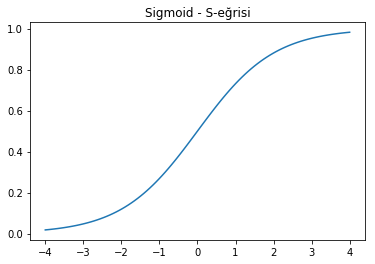

In [2]:
x=linspace(-4,4,100)
y=1/(1+exp(-x))
plot(x,y)
title("Sigmoid - S-eğrisi");

Kodu anlamak isteyenler için: x değişkenine -4 ile 4 arasında 100 eşit parçaya ayrılmış bir seri atıyoruz. Daha sonra sigmoid fonksiyonunu hesaplayarak y değişkenine yüklüyoruz. Çizdirip başlık ekliyoruz.

Fakat bizim bazen daha hızlı bazen ise daha yavaş artan bir s eğrisine ihtiyacımız var. Belki elektrikli arabaların daha hızlı veya yavaş geleceğini öngörmek isteyebiliriz. Bu sebeple sigmoid'imizi biraz değiştirmemiz gerekiyor.

## Geliştirilmiş S-eğrisi 

Şimdi eğrimizi öyle bir formülasyona tabii tutalım ki :
* Bir başlangıç**(basla)** yılından son yıla**(doyum)**
* Farklı hızlarda **(hız)**

bir artış gösterebilsin.
Dolayısıyla aşağıdaki karışık fonksiyon ile bir deneme yapabiliriz. Daha sonra bunu tek başına bir fonksiyon haline getirmeye çalışacağız.

Aşağıdaki grafikte farklı hızlara göre  s-eğrisinin davranışını gözlemleyebilirsiniz. Hız katsayıları grafiğin başlığı şeklinde verilmiştir. Burada şekilsel olarak kullanılan iki fonksiyon var
* subplots_adjust ile grafikler arasındaki boşluklar genişletilmiş
* subplot(satır, sütun, sıra) ile de ardışık grafikleme yapılmıştır

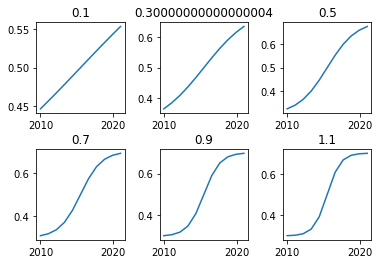

In [3]:
basla=2010
doyum=2020
fark=doyum-basla+1
subplots_adjust(wspace=0.4, hspace=0.4)    # grafikler arasındaki açıklık
for k in range(0,12,2):
    hiz=0.1+k/10
    ilkoran=0.3
    sonoran=0.7
    x=linspace(-fark/2, fark/2,fark)
    y=(1/(1+exp(-hiz*(x))))
    y=y*(sonoran-ilkoran)+ilkoran
    subplot(2,3,floor(k/2)+1)              # aynı figurde ardışık grafikler
    plot(fark/2+basla+x,y)
    title(hiz)                             # başlık 
    pylab.ticklabel_format(axis="both",style='plain', scilimits=(0,0))       #eksenler okunabilir olsun

Yukarıdaki kod biraz karışık gelebilir. Daha basitini aşağıda göreceksiniz. Dikkat edilmesi gereken nokta **hiz** katsayısı 0'a yaklaştıkça s-eğrisi doğrusal bir hale geliyor. 1'e yaklaştıkça da daha da kavisli bir hal alıyor. 

Bu eğriyi nasıl mı kullanacağız? Mesela **2018**(*basla*) yılından **2050**(*doyum*) yılına, 1000 kişiye 151(**ilkoran**)'dan 1000 kişiye 500(**sonoran**) araba düşeceğini ve bu artışın az kavisli (*hiz=0.2*) olacağını öngördüğümüzde bize bu fonksiyonu çıkaracaktır.

İşte tüm bu işlevi yapacak **artis** fonksiyonu aşağıdadır. Bu fonksiyon ile:
 * Nüfus artışının,
 * 1000 kişiye düşen araba sayısının,
 * Elektrikli-hibrit, dizel veya benzinli araç oranlarının değişimini 
belirleyebileceğiz. 

Tüm modelin **kalbi** bu fonksiyon diyebiliriz.

In [4]:
def artis(basla,doyum, hiz,ilkoran, sonoran):
    fark=doyum-basla+1
    x=linspace(-fark/2, fark/2,fark)
    y=(1/(1+exp(-hiz*(x))))            #sigmoid fonksiyonu
    # ---sonuçları normalize ediyoruz ----
    y=y-y[0]
    son=y[len(y)-1]
    y=y/son
    # --- sonuçların normalizasyonu bitti----
    y=y*(sonoran-ilkoran)+ilkoran      # y değerini ilk ve son orana göre kalibre edelim
    x=x+basla+fark/2                   # x değerini basla-doyum arasına uzat
    return x,y

## Modelleme Stratejisi

Modelimizde ana fonksiyonumuz (**artis**) belli olduktan sonra nasıl bir yöntem izleyebileceğimizi tartışabiliriz. Çok farklı yöntemler olmasına rağmen kafayı çok karıştırmamak adına şu şekilde hareket edeceğim:
* Nüfus artışını doğrusal olarak TÜİK projeksiyonundaki 2050 yılı değerine getireceğiz.
* 1000 kişiye düşen araba sayısını 151'den 500'e kavisli bir s-eğrisi ile ,
* Sonra toplam araba miktarını yukarıdaki iki değeri çarparak ,
* Elektrikli-hibrit arabaların 2050'deki oranını rastgele tahmin ederek,
* Diğer yakıtlı araba oranlarından piyasa payları oranında düşerek,

tüm araba rakamlarını tahmin etmeye çalışacağız.

Önce hazırladığımız [Excel](201904-ulastirma.xls) dosyasındaki verileri yükleyerek **cars** değişkenine yükleyelim.

In [5]:
cars=pd.read_excel("201904-ulastirma.xls",sheet_name="cars", index_col='Year')

Her zaman olduğu gibi verimizin ilk 2 ve son 2 satırına bakalım.

In [6]:
cars.head(2) # ilk iki satır

,Total,Car,Minibus,Bus,Small truck,Truck,Motorcycle,vehicles,machinery,Tractor,nufus
Year,,,,,,,,,,,
1966,231977,91469,10913,12041,31462,47931,32099,3610,2452.0,NaN,NaN
1967,284194,112367,16008,13332,39927,56889,39647,3641,2383.0,NaN,NaN


In [7]:
cars.tail(2) # son iki satır

,Total,Car,Minibus,Bus,Small truck,Truck,Motorcycle,vehicles,machinery,Tractor,nufus
Year,,,,,,,,,,,
2017,22218945,12035978,478618,221885,3642625,838718,3102800,60099,NaN,1838222.0,80810525.0
2018,22865921,12398190,487527,218523,3755580,845462,3211328,63359,NaN,1885952.0,82003882.0


Görüldüğü üzere veri setinde tüm nüfus verileri yok. Açıkcası bu model için gerek de yok. Ben daha çok 2000 sonrası ile ilgileniyorum. Bunun içinde bir **post2000** değişkeni ile orjinal verideki son 19 satırı kopyalıyorum. 

In [8]:
post2000=cars.iloc[-19:,]

Sonra da **oran** isimli bir sütunda 1000 kişiye düşen araba sayısını, toplam araba sayısını (**post2000.loc[:,1]**) 'i nüfus'a bölerek (**post2000.loc[:,-1]**) 1000 ile çarpıyoruz. 

In [9]:
post2000.loc[:,"oran"]=(1000*post2000.iloc[:,1]/post2000.iloc[:,-1])

/home/bs/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/bs/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Uyarıya şimdilik dikkat etmeden, veri setimizdeki son 5 satıra bakalım

In [10]:
post2000.tail(5)

,Total,Car,Minibus,Bus,Small truck,Truck,Motorcycle,vehicles,machinery,Tractor,nufus,oran
Year,,,,,,,,,,,,
2014,18828721,9857915,427264,211200,3062479,773728,2828466,40731,NaN,1626938.0,77695904.0,126.878181
2015,19994472,10589337,449213,217056,3255299,804319,2938364,45732,NaN,1695152.0,78741053.0,134.483050
2016,21090424,11317998,463933,220361,3442483,825334,3003733,50818,NaN,1765764.0,79814871.0,141.803123
2017,22218945,12035978,478618,221885,3642625,838718,3102800,60099,NaN,1838222.0,80810525.0,148.940723
2018,22865921,12398190,487527,218523,3755580,845462,3211328,63359,NaN,1885952.0,82003882.0,151.190281


1000 kişiye düşen araba sayısının bir de grafiğini görelim

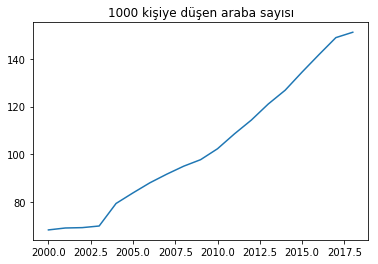

In [11]:
plot(post2000.oran)
title("1000 kişiye düşen araba sayısı");

Görüldüğü üzere Türkiye'de 1000 kişiye düşen araba sayısı 15 yılda neredeyse 2 misline çıkmış nispeten daha doğrusal artmış.

###  Araba sayısı tahmini

Mevcut trendin benzer şekilde devam edeceğini, fakat doğrusaldan daha çok az kavisli bir s-eğrisine benzeyeceğini öngörebiliriz.
Yani 2050'de 500 araba/1000 kişiye hiz=0.2 (*hatırlarsak 0.1 doğrusaldı, 0.2 az kavisli olur*) ile çıkacağımızı kabul ediyoruz. Daha önce yazdığımız **artis** fonksiyonuna ilgili değişkenleri giriyoruz.

*artis(baslangic_yili=2018, son_yil=2050, hız=0.2, ilk değer =151, son değer = 500)*

In [12]:
x,y=artis(2018,2050,0.2,151,500)

Her zaman olduğu gibi sonuçlarımızı bir çizdirelim. Başlığımızı da unutmayalım.

Text(0.5, 1.0, '2050 yılına kadar 1000 kişiye düşen araç sayısının gelişimi')

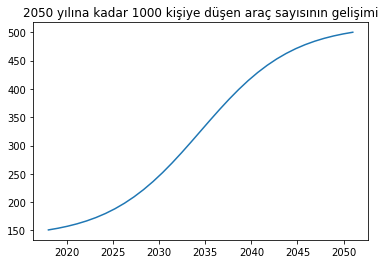

In [13]:
plot(x,y)
title("2050 yılına kadar 1000 kişiye düşen araç sayısının gelişimi")

 ### Nüfus artış tahmini
 
Nüfus projeksiyonu excel dosyasında var. Fakat yine s-eğrisi ile nispeten doğrusal ilk değer-son değer yaklaşımı ile bir nüfus öngörüsü de hesaplayabiliriz. Bu sefer hızımız 0.1, ilk değerimiz 83 milyon, son değerimiz de 105 milyon olsun

In [14]:
pop_x, pop_y=artis(2018, 2050, 0.1, 83000000,105000000)

Text(0.5, 1.0, "2050'ye nüfus projeksiyonu")

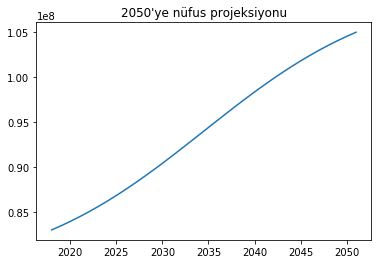

In [15]:
plot(pop_x, pop_y)
title("2050'ye nüfus projeksiyonu")

Bazen veri setimizde kaç değişken olduğunu bilmek faydalı olabilir. Bunun için **len** komutunu kullanıyoruz.

In [16]:
len(pop_y)

33

33 değişken var, ama 0'dan başladığından son değişkenin kaç olduğuna bakmak için 32nci indeksi çağırıyoruz.

In [17]:
pop_y[0]

83000000.0

In [18]:
pop_y[32]

105000000.0

Evet ilk değerimi 83 milyon ve son değerimiz 105 milyon. Tüm değerlerimiz sınırlarında.

### Araba sayısının hesabı

Türkiye'nin 2050 yılına nüfus gelişimi **pop_y** değişkenindeydi. 2050 yılındaki, araba sayısı/1000 kişi y değişkeninde saklanmıştı. Şimdi iki rakamı çarpıp 1000'e bölerek (rakam 1000 kişiye düşen araç sayısıydı), Türkiye'de 2050 yılındaki toplam araba sayısını hesaplayabiliriz.

Text(0.5, 1.0, '2050 yılına toplam araba sayısı gelişimi')

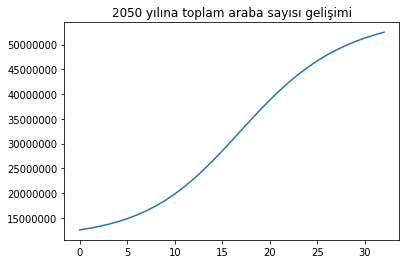

In [19]:
toplam_araba=pop_y*y/1000
plot(toplam_araba)
pylab.ticklabel_format(axis="both",style='plain', scilimits=(0,0))
title("2050 yılına toplam araba sayısı gelişimi")

### Verileri bir araya getirmek

Şimdi elimizde, 2050 yılına nüfus tahmini, 1000 kişiye düşen araba sayısı ve çarpımlarının 1000'e bölümü olan araba sayısı var. Tüm bunları bir veri çerçevesinde toplayalım.

Öncelikle 2018'den 2050'ye yıl verilerini oluşturalım. **range** komutunda son yıl dahil olmadığından 2051 yazıyoruz.

In [20]:
yil=range(2018,2051,1)

In [21]:
len(yil)

33

Bu kısımı kendim için de not alıyorum. Eğer 3-4 veri serisini bir araya getirecek isek, bunların transpozu yani döndürülmüş halini almamız gerekiyor. Bunun için de **.T** komutu ile çeviriyoruz. Sütunlarımız belli: yıl, nüfus, araba oranı ve toplam araba sayısı. 

İstersek bu birlikteliği **ilksonuclar** diye bir değişkene atayabiliriz. Ama daha işimiz bitmediği için sadece gösteriyoruz. Son kısımdaki **.astype(int)** ile de tüm değişlenlerimizi tamsayıya çevirmiş oluyoruz. Yoksa yıllar dahil noktalı sayı formatında geliyor.

In [22]:
pd.DataFrame(np.vstack((yil, pop_y, y, pop_y*y/1000)).T,columns=['Yıl','Nufus','Araba Oranı','Araba Sayısı']).astype(int)

,Yıl,Nufus,Araba Oranı,Araba Sayısı
0,2018,83000000,151,12533000
1,2019,83468352,153,12848172
2,2020,83969101,157,13222108
3,2021,84502789,161,13665364
4,2022,85069654,166,14189837
5,2023,85669596,172,14808625
6,2024,86302128,180,15535719
7,2025,86966346,188,16385442
8,2026,87660902,198,17371616
9,2027,88383984,209,18506394


Veriye baktığımızda 2018'deki 12.5 milyon arabadan 2050'de 52.5 milyon arabaya bir artışın olduğu görülecektir. Hatırlarsanız bu 1000 kişiye 500 araba sayısı Avrupa ortalamasına yakın bir değer. S-eğrisinin yapısından dolayı son değerler hedeflerimizin biraz etrafında gerçekleşmiştir.

# Yakıtlara göre araba dağılımı tahmini

Şimdi aynı Excel dosyamızdaki **carshare** alt sayfasını kullanarak şu ana kadar değişik yakıt kullanımlarına göre arabaların payının nasıl değiştiğine bakalım.

Önce veri dosyamızı yükleyerek son 2 yıla bakalım. Dosyada Türkçe karakterler sorun çıkarır diye bazı kısaltmalara gitmiştim. 
* gas_p : benzin oranı. Sonu *_p* ile biten tüm değişkenler orandır. 
* eh : elektrikli ve hibrit araç oranları. Hibrit araçlar aynı zamanda benzin de kullanabilirler. Bu tartışmaya girmedik

In [23]:
fuel=pd.read_excel("201904-ulastirma.xls",sheet_name="carshare", index_col='Year')

In [24]:
fuel.tail(2)

,Total,Gasoline,gas_p,Diesel,diesel_p,LPG,lpg_p,eh,eh_p,unknown,unknown_p
Year,,,,,,,,,,,
2017,12035978,3120407,25.925662,4256305,35.363184,4616842,38.358678,1685,0.0139997,40739,0.338477
2018,12398190,3089626,24.919976,4568665,36.849451,4695717,37.874214,5367,0.0432886,38815,0.313070


Tüm veri seti ile ilgilenmiyoruz. Sadece oranları alarak **fuel** değişkeninin üzerine yazıyoruz.
* ['gas_p', 'diesel_p','lpg_p','eh_p'] ile "bu isimleri bir dizi halinde verilen sütunlardaki verileri al" demiş oluyoruz.

In [25]:
fuel=fuel.loc[:, ['gas_p', 'diesel_p','lpg_p','eh_p']]

Daima veriyi çizdirerek veri setinin neye benzediğini görelim.

Text(0.5, 1.0, 'Yakıt kullanımlarına göre arabaların oranı (%)')

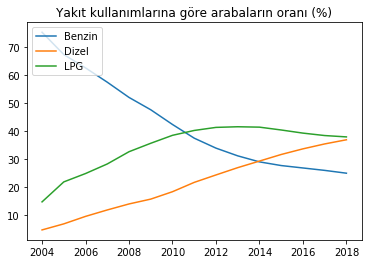

In [26]:
plot(fuel.gas_p, label="Benzin")
plot(fuel.diesel_p, label="Dizel")
plot(fuel.lpg_p, label="LPG")
#plot(fuel.eh_p) # elektrikli araçlarda boş satırlar var ve veri çok küçük gözükmüyor
legend(loc='upper left');
title("Yakıt kullanımlarına göre arabaların oranı (%)")

## Yakıt kullanımına göre araba oranları tahmini

Yukarıdaki grafikte dizelin hızla arttığını gördük. Bu artışın artık hız kesip bir süre sabit kalacağı daha sonra ise düşeceğini öngörebiliriz. Yani 2018deki %36.8 oranından, 2050'de %25'e önce yavaş daha sonra ise hızlı bir oran ile dizelin payı düşerek Türkiye'deki her 4 arabadan 1'i dizel olabilir. (***Bu gerçek tahmin değildir, sadece sayısallaştırmak için örneklemedir***)

In [27]:
x,diesel_x=artis(2018,2050,0.3,36.8,25)

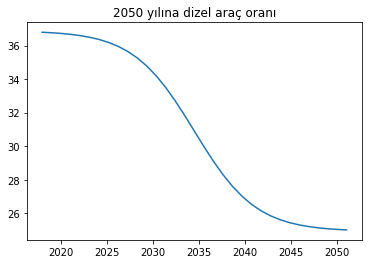

In [28]:
plot(x,diesel_x)
title("2050 yılına dizel araç oranı");

Şimdi de benzinli araç oranında önce çok yavaş fakat daha sonra hızlanan bir artış öngörelim. Fakat bu artış %25'ten %30'a çıkmış olsun. Hız değişkenini 0.4 yaparak önce yavaş sonra hızlanan bir dönüşüm elde edebiliriz.

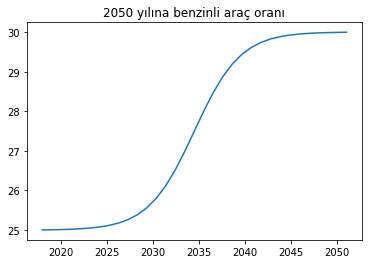

In [29]:
x,gas_x=artis(2018,2050,0.4,25,30)
plot(x, gas_x)
title("2050 yılına benzinli araç oranı");

LPGli araç payı da %37.8'den %20'lere doğrusal bir iniş yapsın. Kısaca 3 ayrı yakıtta 3 ayrı değişim şeklini de görmüş olalım

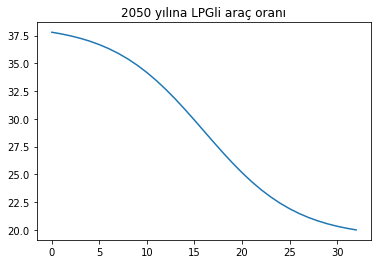

In [30]:
x,lpg_x=artis(2018,2050,0.2,37.8,20)
plot(lpg_x)
title("2050 yılına LPGli araç oranı");

### Elektrikli/hibrit arabalara ne kaldı?

Peki tüm bu öngörülerden sonra elektrikli/hibrit(EH) arabalara kalan pay ne oldu? Bunun için tüm değişkenlerin son satırlarını toplayarak 100'den çıkarıyoruz.

In [31]:
100-(lpg_x[-1]+gas_x[-1]+diesel_x[-1])

25.0

EH arabalara 2050 yılında kalan pay %25. Öyleyse bu artışı %0'dan %25'e, kavisli bir artış ile sisteme tanıtalım

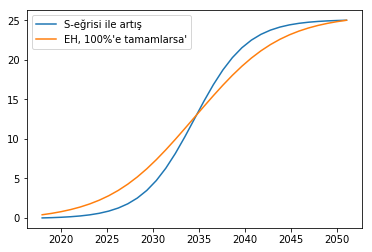

In [32]:
x,eh_x=artis(2018, 2050, 0.35,0,25)
plot(x,eh_x,label="S-eğrisi ile artış")

eh_x=100-(lpg_x+gas_x+diesel_x)
plot(x,eh_x, label= "EH, 100%'e tamamlarsa'")

legend(loc='upper left');


Modellerde aşama aşama sürekli kontrol etmek gerekebilir. Bu aşama bu durumlardan biri oluştu. Bizim öngördüğümüz artış oranı ile diğer yakıtlardaki düşüşten elektriğe kalan oran birbirinden farklılaştı. Fakat en son **eh_x** değişkeni 100%'den geriye kalanlar olduğu için böyle de devam edebiliriz. Yani turuncu eğriyi göz önüne alacağız.

### Oranların görülmesi

Verinin daima farklı grafikleme yöntemleri ile de kontrol edilmesinde fayda var. Şimdi de yığılmış alan grafiği ile arabaların yakıtlara göre oranlarına bir bakalım. Çizim için **stackplot** komutunu kullanacağız. 

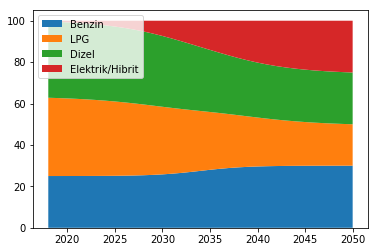

In [33]:
# Basic stacked area chart.
plt.stackplot(range(2018,2051,1),gas_x, lpg_x, diesel_x, eh_x, labels=['Benzin','LPG','Dizel', 'Elektrik/Hibrit'])
plt.legend(loc='upper left')

# Yöntem 2 - Önce Elektrik/Hibrit(EH) araba gelişimini belirlemek

Az önceki senaryoda, diğer yakıt türlerine sahip arabaların oranlarını ve gelişimlerini belirleyerek geri kalanın EH arabalar olacağını kabul etmiştik. Şimdi ise diğer taraftan yaklaşalım.
* 2050'de tüm arabaların %50'si EH araba olacağını kabul edelim.
* EH'lardaki artışın diğer yakıt türlerinden payları oranında eksiltilerek devam edeceğini öngörelim.

Dolayısıyla bu yöntemde belirlememiz gereken iki değişken var. 
* Elektrikli/hibrit arabaların 2050 yılındaki oranı
* EH arabaların hangi hız ile sisteme gireceği

Bu kısma da **Senaryo Üreticisi** diyelim

In [34]:
# Önce elektrik arabaların sisteme ne hızda geleceğini belirleyelim
eh_sonoran=50 # yani %50
eh_degisim_hizi=0.3
x,eh_x=artis(2018, 2050, eh_degisim_hizi,0,eh_sonoran)

# 2018 yılındaki oranları ana değişkenlere tanıtalım 
dizel_ilk=fuel.diesel_p.iloc[-1]
benzin_ilk=fuel.gas_p.iloc[-1]
lpg_ilk=fuel.lpg_p.iloc[-1]

# her yılın değişkenini saklamak için listeler oluşturalım

dizel_a=[];
benzin_a=[]; 
lpg_a=[];
eh_a=[];

for i in range(2018,2051,1):
    syc=i-2018
    toplam=dizel_ilk+benzin_ilk+lpg_ilk+eh_x[syc]
    
    # eğer toplam 100%'ün üzereinde ise fark'ı tüm kaynaklardan 2018 yılı oranları oranında çıkar
    if (toplam>100):      
        fark=toplam-100.001
        dizel_ilk=dizel_ilk-(fark*dizel_ilk/100)
        benzin_ilk=benzin_ilk-(fark*benzin_ilk/100)
        lpg_ilk=lpg_ilk-(fark*lpg_ilk/100)
        eh_x[syc]=eh_x[syc]+(100-lpg_ilk-benzin_ilk-dizel_ilk-eh_x[syc])
    # kontrol amaçlı
    # print(eh_x[syc]," ",dizel_ilk," ", benzin_ilk," ", lpg_ilk," ", (dizel_ilk+benzin_ilk+lpg_ilk+eh_x[syc]) )
    
    # hesaplanan değişkenleri listelerin sonuna ekle
    dizel_a.append(dizel_ilk)
    benzin_a.append(benzin_ilk)
    lpg_a.append(lpg_ilk)
    eh_a.append(eh_x[syc])
    


Grafiklendirme de ise hesapladığımız değerleri yığılmış alan grafiği haline getiriyoruz.

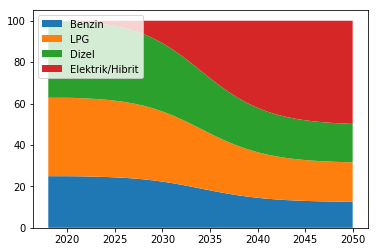

In [35]:
# Basic stacked area chart.
plt.stackplot(range(2018,2051,1),benzin_a, lpg_a, dizel_a, eh_x, labels=['Benzin','LPG','Dizel', 'Elektrik/Hibrit'])
plt.legend(loc='upper left')

Kodlama yaparken bazı kontrol noktaları bırakmak gerekir. Aşağıdaki kod aktif değil. Bir açıklama gibi gözüküyor. Ama program doğru çalışmaz ise açıklama için kullanılan **#** ları silerek kodun tamamında neyin ters gittiğini görebiliriz.

In [36]:
# Kontrol noktası - sorun olursa veride ne olduğunu buradan gör
# pd.DataFrame(np.vstack((yil, pop_y, y,dizel_a,benzin_a,lpg_a,eh_a)).T,columns=['Yil','nufus',
# 'Araba Oranı', 'Dizel Oran','Benzin Oran','LPG Oran','EH Oran']).astype(int)

# Sonuç tablosu

Şimdi tüm verileri hesapladık. Oranlar **dizel_a, benzin_a ...** gibi değişkenlerin içindedir. Hesapladığımız değerleri şimdi bir veri çerçevesine yükleyelim. Daha sonra, bu hesapladığımız oranlardan araba sayılarını hesaplayacağız.

Önce sırası ile "Yıl"(yil), "Nüfus tahmini"(pop_y), "Dizel araç oranı"(dizel_a), "Benzinli araç oranı"(benzin_a),"LPGli araç oranı"(lpg_a),"EH araç oranı"(eh_a) rakamlarını **tahmin** isimli bir veri çerçevesi (DataFrame) yapıyoruz.

In [37]:
tahmin=pd.DataFrame(np.vstack((yil, pop_y, y,dizel_a,benzin_a,lpg_a,eh_a)).T,columns=['Yil','Nüfus',
                                                                               'Araba Oranı',
                                                                               'Dizel Oran','Benzin Oran','LPG Oran','EH Oran'])

In [38]:
tahmin.head(2)

,Yil,Nüfus,Araba Oranı,Dizel Oran,Benzin Oran,LPG Oran,EH Oran
0,2018.0,8.300000e+07,151.000000,36.849451,24.919976,37.874214,0.000000
1,2019.0,8.346835e+07,153.928671,36.849451,24.919976,37.874214,0.128093


Şimdi de sırası ile 
* Toplam Araba Sayısını : Nüfus *  Araba Oranı /1000 , yani 1 ve 2. sütun çarpılıyor (**UYARI: Python'da satır/sütun 0'dan başlar, 1.sütun sıralamada 2. sıradadır**)
* Diğer araç sayıları da Nüfus* (Araba Oranı/1000) * (Yakıtlı Araç oranı/100) ile elde edilir.

In [39]:
tahmin.loc[:,"Toplam Araba Sayısı"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]/(1000))
tahmin.loc[:,"Dizel Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,3]/(1000*100))
tahmin.loc[:,"Benzinli Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,4]/(1000*100))
tahmin.loc[:,"LPGli Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,5]/(1000*100))
tahmin.loc[:,"EH Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,6]/(1000*100))

Şimdi tüm hesaplamaları tam sayı yaparak, noktadan sonraki kısımları silelim. Bunun için  **astype(int)** kullanacağız.
Sonucu ekrana yazalım.

In [40]:
tahmin=tahmin.astype(int)
tahmin.tail(2)

,Yil,Nüfus,Araba Oranı,Dizel Oran,Benzin Oran,LPG Oran,EH Oran,Toplam Araba Sayısı,Dizel Arac,Benzinli Arac,LPGli Arac,EH Arac
31,2049,104531647,497,18,12,19,49,51959685,9678632,6545315,9947789,25787947
32,2050,105000000,500,18,12,19,49,52500000,9743259,6589020,10014213,26153506


Burada çok ilginç bir sonuç karşımıza çıkıyor. Araba oranı Avrupa ortalamasını yakaladığında toplam araba sayısı 52.5 milyon oluyor. Dizel araba sayısı 9.7 milyon, benzin+LPG'li araç sayısı ise 16.5 milyon, elektrikli/hibrit araba sayısı ise 26 milyon oluyor. Yani geleneksel fosil yakıtlı araba sayısı bugünkinden fazla oluyor.

Bu durumu bir de yığımlı alan grafiği ile görelim

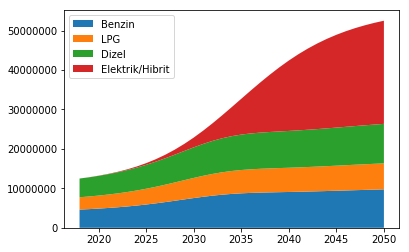

In [41]:
plt.stackplot(yil,tahmin.iloc[:,8],tahmin.iloc[:,9],tahmin.iloc[:,10],tahmin.iloc[:,11], labels=['Benzin','LPG','Dizel', 'Elektrik/Hibrit'])
plt.legend(loc='upper left')
pylab.ticklabel_format(axis="both",style='plain', scilimits=(0,0))

### Tüm tahmin ve Excel'e aktarılması

Şimdi tüm tahminimizi hem görelim hem de Excel dosyasına aktaralım.

**tahmin** yazarak tüm veri setini görelim.

Daha sonra da 

**tahmin.to_excel("Dosya.xls")** ile excel dosyasına yazacağız. ***HATIRLATMA: Excel dosyası yazabilmek için xlwt paketi yüklü olmalı.***  **pip install xlwt** ile yüklenebilir.

In [42]:
tahmin

,Yil,Nüfus,Araba Oranı,Dizel Oran,Benzin Oran,LPG Oran,EH Oran,Toplam Araba Sayısı,Dizel Arac,Benzinli Arac,LPGli Arac,EH Arac
0,2018,83000000,151,36,24,37,0,12533000,4618341,3123220,4746775,0
1,2019,83468352,153,36,24,37,0,12848172,4734481,3201761,4866144,16457
2,2020,83969101,157,36,24,37,0,13222108,4872274,3294946,5007769,39875
3,2021,84502789,161,36,24,37,0,13665364,5026613,3399320,5166400,73030
4,2022,85069654,166,36,24,37,0,14189837,5203007,3518609,5347700,120519
5,2023,85669596,172,36,24,37,1,14808625,5406777,3656411,5557136,188299
6,2024,86302128,180,36,24,37,1,15535719,5639916,3814075,5796759,284968
7,2025,86966346,188,36,24,37,2,16385442,5903287,3992183,6067454,422517
8,2026,87660902,198,35,24,36,3,17371616,6195962,4190109,6368268,617275
9,2027,88383984,209,35,23,36,4,18506394,6514477,4405509,6695641,890765


In [43]:
tahmin.to_excel("sonuclar.xls")

# Sonuç

Türkiye'de elektrik ve hibrit arabaların artışını bir teknolojik yayılma olarak düşünürsek, bunu s-eğrisi ile modelleyebiliriz. Bu çalışmada sigmoid yani s-eğrisi ile 2 yöntem ile geleceğe dair kurgusal araba senaryoları sayısallaştırıldı. 
1. Yöntemde diğer araçların 2050 yılına düşecekleri paylar hesaplanarak artık payın EH arabalar olacağı varsayıldı.
2. Yöntemde ise EH arabaların 2050 yılında gelecekleri paylar hesaplanarak diğer yakıtlı arabalardan payları oranında eksiltme yapıldı.

Belki de en önemli kabulumuz ise
* 2050 yılında 1000 kişiye düşen araba sayısının Avrupa'nın bugün ki seviyesinde olacağı kabul edildi.

Dolayısıyla ilginç bir sonuca geldik. EH arabalar 2050'e %50 paya sahip de olsa, 2050 yılındaki dizel, benzinli ve LPG'li araç sayısı bugünden fazla oluyor. Burada toplam araba sayısını AB'de toplu taşıma/bisiklet gibi araçları en çok kullanan Hollanda ve Danimarka'nın bugünki durumlarını da baz aldığımız unutulmamalıdır.

Bu defterdeki kodlar daha bilimsel öngörüler ile desteklenerek tekrar hesaplanabilir. Farklı hesaplarınızı mutlaka bekliyorum.



Barış Sanlı (barissanli2@gmail.com)

14 Nisan 2018


# EK - Toplu Senaryo Üretimi

Populating the interactive namespace from numpy and matplotlib


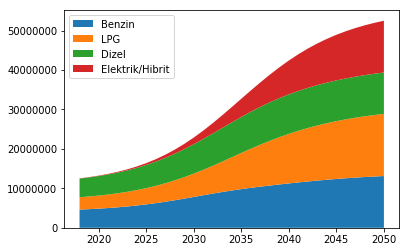

In [44]:
#  -------------------------------
#    YÖNTEM 1
#   Benzin, Dizel, LPG'nin 2050 yılı oranları belirlendikten sonra geriye kalan elektrikli/hibrit araç kabul edilir.
#  -------------------------------


%pylab inline
import pandas as pd

nufus_2050=105000000
araba_orani_2050=500
dizel_payi_2050=25
benzin_payi_2050=30
lpg_payi_2050=20

def artis(basla,doyum, hiz,ilkoran, sonoran):
    fark=doyum-basla+1
    x=linspace(-fark/2, fark/2,fark)
    y=(1/(1+exp(-hiz*(x))))            #sigmoid fonksiyonu
    # ---sonuçları normalize ediyoruz ----
    y=y-y[0]
    son=y[len(y)-1]
    y=y/son
    # --- sonuçların normalizasyonu bitti----
    y=y*(sonoran-ilkoran)+ilkoran      # y değerini ilk ve son orana göre kalibre edelim
    x=x+basla+fark/2                   # x değerini basla-doyum arasına uzat
    return x,y



yil=range(2018,2051,1)
pop_x, pop_y=artis(2018, 2050, 0.1, 83000000,nufus_2050)
x,y=artis(2018,2050,0.2,151,araba_orani_2050)
x,diesel_x=artis(2018,2050,0.3,36.8,dizel_payi_2050)
x,gas_x=artis(2018,2050,0.4,25,benzin_payi_2050)
x,lpg_x=artis(2018,2050,0.2,37.8,lpg_payi_2050)
eh_x=100-(lpg_x+gas_x+diesel_x)
tahmin=pd.DataFrame(np.vstack((yil, pop_y, y,diesel_x,gas_x,lpg_x,eh_x)).T,columns=['Yil','Nüfus',
                                                                               'Araba Oranı',
                                                                               'Dizel Oran','Benzin Oran','LPG Oran','EH Oran'])
tahmin.loc[:,"Toplam Araba Sayısı"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]/(1000))
tahmin.loc[:,"Dizel Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,3]/(1000*100))
tahmin.loc[:,"Benzinli Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,4]/(1000*100))
tahmin.loc[:,"LPGli Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,5]/(1000*100))
tahmin.loc[:,"EH Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,6]/(1000*100))
tahmin=tahmin.astype(int)


plt.stackplot(yil,tahmin.iloc[:,8],tahmin.iloc[:,9],tahmin.iloc[:,10],tahmin.iloc[:,11], labels=['Benzin','LPG','Dizel', 'Elektrik/Hibrit'])
plt.legend(loc='upper left')
pylab.ticklabel_format(axis="both",style='plain', scilimits=(0,0))

Populating the interactive namespace from numpy and matplotlib


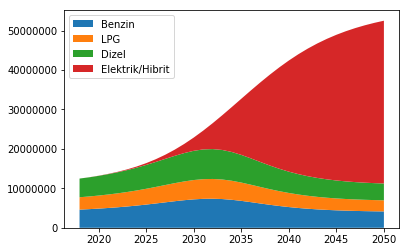

In [45]:
#  -------------------------------
#    YÖNTEM 2
#   EH arabaların 2050 payı ve yayılım hızı belirlenir, diğer yakıtlardan eksiltilir
#  -------------------------------

%pylab inline
import pandas as pd

nufus_2050=105000000
araba_orani_2050=500
eh_payi_2050=80
eh_artis_hizi=0.35

def artis(basla,doyum, hiz,ilkoran, sonoran):
    fark=doyum-basla+1
    x=linspace(-fark/2, fark/2,fark)
    y=(1/(1+exp(-hiz*(x))))            #sigmoid fonksiyonu
    # ---sonuçları normalize ediyoruz ----
    y=y-y[0]
    son=y[len(y)-1]
    y=y/son
    # --- sonuçların normalizasyonu bitti----
    y=y*(sonoran-ilkoran)+ilkoran      # y değerini ilk ve son orana göre kalibre edelim
    x=x+basla+fark/2                   # x değerini basla-doyum arasına uzat
    return x,y

yil=range(2018,2051,1)
pop_x, pop_y=artis(2018, 2050, 0.1, 83000000,nufus_2050)
x,y=artis(2018,2050,0.2,151,araba_orani_2050)
x,eh_x=artis(2018, 2050, eh_artis_hizi,0,eh_payi_2050)


# 2018 yılındaki oranları ana değişkenlere tanıtalım 
dizel_ilk=36.8
benzin_ilk=25
lpg_ilk=37.8

# her yılın değişkenini saklamak için listeler oluşturalım

dizel_a=[];
benzin_a=[]; 
lpg_a=[];
eh_a=[];

for i in range(2018,2051,1):
    syc=i-2018
    toplam=dizel_ilk+benzin_ilk+lpg_ilk+eh_x[syc]
    
    # eğer toplam 100%'ün üzereinde ise fark'ı tüm kaynaklardan 2018 yılı oranları oranında çıkar
    if (toplam>100):      
        fark=toplam-100.001
        dizel_ilk=dizel_ilk-(fark*dizel_ilk/100)
        benzin_ilk=benzin_ilk-(fark*benzin_ilk/100)
        lpg_ilk=lpg_ilk-(fark*lpg_ilk/100)
        eh_x[syc]=eh_x[syc]+(100-lpg_ilk-benzin_ilk-dizel_ilk-eh_x[syc])

    # hesaplanan değişkenleri listelerin sonuna ekle
    dizel_a.append(dizel_ilk)
    benzin_a.append(benzin_ilk)
    lpg_a.append(lpg_ilk)
    eh_a.append(eh_x[syc])
    
tahmin=pd.DataFrame(np.vstack((yil, pop_y, y,dizel_a,benzin_a,lpg_a,eh_a)).T,columns=['Yil','Nüfus',
                                                                               'Araba Oranı',
                                                                               'Dizel Oran','Benzin Oran','LPG Oran','EH Oran'])

tahmin.loc[:,"Toplam Araba Sayısı"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]/(1000))
tahmin.loc[:,"Dizel Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,3]/(1000*100))
tahmin.loc[:,"Benzinli Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,4]/(1000*100))
tahmin.loc[:,"LPGli Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,5]/(1000*100))
tahmin.loc[:,"EH Arac"]=(tahmin.iloc[:,1]*tahmin.iloc[:,2]*tahmin.iloc[:,6]/(1000*100))

tahmin=tahmin.astype(int)

plt.stackplot(yil,tahmin.iloc[:,8],tahmin.iloc[:,9],tahmin.iloc[:,10],tahmin.iloc[:,11], labels=['Benzin','LPG','Dizel', 'Elektrik/Hibrit'])
plt.legend(loc='upper left')
pylab.ticklabel_format(axis="both",style='plain', scilimits=(0,0))